# Personalized Restaurant Recommendations

Group Members

* Elsie Serem
* Nancy Maina
* Andrew Manwa
* Martin Omondi
* Samuel Gathogo



## BUSINESS UNDERSTANDING

### Introduction

Introduction
Savor Space is a growing tourism and travel agency offering a wide range of services; from booking accommodations to providing tour guides and creating personalized travel experiences. Our mission is to ensure that tourists have an enriching and seamless journey hence fully enjoying their destination.

We believe that traveling is about more than just sightseeing,it's also about savoring local cuisines that suit individual tastes. Whether a tourist is looking for traditional dishes, vegan options, or a fine dining experience, finding their preferred restaurant guarantees a satisfying experience. To enhance this specific aspect of their journey, Savor Space is developing a restaurant recommendation system designed to help tourists discover dining spots that align with their preferences,ensuring a memorable and enjoyable culinary experience.

### Business Problem

Its not easy for a majority of tourists to find restaurants that align with their tastes, especially when visiting unfamiliar locations. Lack of personalized recommendations means that they may rely on random reviews, which do not always reflect their preferences or specific dining needs. The lack of tailored suggestions can negatively impact a tourist's overall experience. The problem Savor Space seeks to solve is how to provide accurate and personalized restaurant recommendations based on individual preferences, allowing tourists to easily find eateries they will enjoy.

Stakeholders

Savor Space Management: An interest in offering personalized and innovative services to boost customer satisfaction and retention thus positvely impacting their ROI.

Tourists: Seeking personalized restaurant recommendations that match their tastes hence improving their travel experience.

Restaurant Owners: Although they are not directly involved, they may benefit from increased traffic when their restaurant is recommended in alignment with customer preferences.

Objectives


1. To develop a robust restaurant recommendation system- this offers personalized restaurant suggestions based on user preferences, past behaviors, and restaurant reviews.

2. To improve tourist satisfaction- this is done by enabling them discover restaurants that match their individual tastes, enhancing their overall travel experience.

3. To leverage data science techniques-these include: Natural Language Processing (NLP) and recommendation algorithms (content-based and collaborative filtering) to ensure accurate and reliable recommendations.

4. To evaluate and improve the recommendation system- can be achieved by using advanced models and performance metrics like RMSE to optimize the system's accuracy.

Data Understanding

In order to come up with a cutting edge restaurant recommendation system, we opted to get real-time data from Yelp.com. The data was extracted through web scraping and a total of five json datasets were obtained.

Files Obtained:

business.json
checkin.json
review.json
tips.json
user.json


This restaurant recommendation system leverages two primary datasets namely the business.json and the review.json as the had relevant information required to develop the recmmendation system.

1) Business Dataset

This dataset includes essential information about a variety of restaurants. The columns found in this dataset include:

business_id
name
address
city
state
postal_code
latitude
longitude
stars
review_count
is_open
attributes
categories
hours


2) Review Dataset

This dataset provides insights into user preferences and their dining experiences. The columns in this dataset include:

user_id
business_id
stars
date
text
useful
funny
cool

In [20]:
# importing the necesarry libraries

import collections
import folium
import json 
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string
import pickle
from surprise import Reader , Dataset
from tabulate import tabulate
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow.keras import models ,layers, optimizers , losses, regularizers, metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud



In [21]:
# Initialize an empty list to store the data
json_data = []

# Define the number of lines to read (54380)
lines_to_read = 54380

# Open the JSON file and read the specified number of lines
with open(r"C:\Users\USER PC\Downloads\data\yelp_academic_dataset_business.json", 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):  
        if i >= lines_to_read:       
            break
        # Load each line as a JSON object
        json_object = json.loads(line)
        json_data.append(json_object)

# Convert the json_data list into a pandas DataFrame
business_df = pd.DataFrame(json_data)

# Display the first few rows of the DataFrame
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [22]:
import csv
# adjust this value according to your memory constraints
chunk_size = 1000  

with open(r"C:\Users\USER PC\Downloads\data\yelp_academic_dataset_review.json", 'r') as f:
    with open('yelp_review_sample.csv', 'w', newline='') as csvfile:
        fieldnames = ['review_id', 'user_id', 'business_id', 'stars', 'date', 'text', 'useful', 'funny', 'cool']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        count = 0
        for line in f:
# parse each line as a separate JSON object
            data = json.loads(line)  
            writer.writerow(data)
            count += 1
            if count >= 54380:
                break
 

In [23]:
review_df = pd.read_csv('yelp_review_sample.csv')

# Display the first few rows of the Data
review_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is...",0,0,0
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,2012-01-03 15:28:18,I've taken a lot of spin classes over the year...,1,0,1
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,2014-02-05 20:30:30,Family diner. Had the buffet. Eclectic assortm...,0,0,0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03,"Wow! Yummy, different, delicious. Our favo...",1,0,1
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,Cute interior and owner (?) gave us tour of up...,1,0,1


In [24]:
# viewing the datas features
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54380 entries, 0 to 54379
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   54380 non-null  object 
 1   name          54380 non-null  object 
 2   address       54380 non-null  object 
 3   city          54380 non-null  object 
 4   state         54380 non-null  object 
 5   postal_code   54380 non-null  object 
 6   latitude      54380 non-null  float64
 7   longitude     54380 non-null  float64
 8   stars         54380 non-null  float64
 9   review_count  54380 non-null  int64  
 10  is_open       54380 non-null  int64  
 11  attributes    49543 non-null  object 
 12  categories    54342 non-null  object 
 13  hours         45975 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 5.8+ MB


In [25]:

review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54380 entries, 0 to 54379
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    54380 non-null  object 
 1   user_id      54380 non-null  object 
 2   business_id  54380 non-null  object 
 3   stars        54380 non-null  float64
 4   date         54380 non-null  object 
 5   text         54380 non-null  object 
 6   useful       54380 non-null  int64  
 7   funny        54380 non-null  int64  
 8   cool         54380 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.7+ MB


In [26]:
# merging the two datasets into one using the business_id primary key

restaurant_df=pd.merge(left=review_df , right=business_df, how='left', on='business_id')

# previewing the new merge dataset
restaurant_df.head()

,review_id,user_id,business_id,stars_x,date,text,useful,funny,cool,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is...",0,0,0,Turning Point of North Wales,...,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,2012-01-03 15:28:18,I've taken a lot of spin classes over the year...,1,0,1,Body Cycle Spinning Studio,...,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,2014-02-05 20:30:30,Family diner. Had the buffet. Eclectic assortm...,0,0,0,Kettle Restaurant,...,AZ,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03,"Wow! Yummy, different, delicious. Our favo...",1,0,1,Zaika,...,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,Cute interior and owner (?) gave us tour of up...,1,0,1,Melt,...,LA,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '..."


In [27]:
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54380 entries, 0 to 54379
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_id     54380 non-null  object 
 1   user_id       54380 non-null  object 
 2   business_id   54380 non-null  object 
 3   stars_x       54380 non-null  float64
 4   date          54380 non-null  object 
 5   text          54380 non-null  object 
 6   useful        54380 non-null  int64  
 7   funny         54380 non-null  int64  
 8   cool          54380 non-null  int64  
 9   name          54380 non-null  object 
 10  address       54380 non-null  object 
 11  city          54380 non-null  object 
 12  state         54380 non-null  object 
 13  postal_code   54380 non-null  object 
 14  latitude      54380 non-null  float64
 15  longitude     54380 non-null  float64
 16  stars_y       54380 non-null  float64
 17  review_count  54380 non-null  int64  
 18  is_open       54380 non-nu

## Data Preparation

In this section, we will perform data cleaning to prepare the dataset for analysis, the various data cleaning methods that are to be used will be;

- Renaming columns
- Checking Dealing with missing data
- Dropping unnecesary columns 
- Feature Engineering
- Selecting the Relevant Columns
- Selecting relevant rows

In [28]:
#Renaming the columns stars_x and star_y into rarings and b/s rating
restaurant_df.rename(columns={'stars_x':'rating', 'stars_y':'b/s_rating'}, inplace=True)

### Dealing with missing data
In order to avoid inaccurate insights we have to deal with duplicate data because duplicate data can lead to incorrect or misleading insights.

In [29]:
# checking for columns with missing values
restaurant_df.isna().sum()

review_id          0
user_id            0
business_id        0
rating             0
date               0
text               0
useful             0
funny              0
cool               0
name               0
address            0
city               0
state              0
postal_code        0
latitude           0
longitude          0
b/s_rating         0
review_count       0
is_open            0
attributes       842
categories         2
hours           3101
dtype: int64

> The main columns in our analysis, that will be used to develop the recommendation system are **user_id**, **business_id** and **rating**. Therefore, since the columns that have missing values only provide metadata/ more information about our restaurants i.e **attribute, categories** **and hours**, then we will impute the missing values with "Not-Available" since they won't influence our analysis 


In [30]:

# Imputing missing values in the attributes column with "Not-Available" 
restaurant_df.attributes.fillna(value="Not-Available", inplace=True)

In [31]:

# Imputing missing values in the categories column with "Not-Available" 
restaurant_df.categories.fillna(value="Not-Available", inplace=True)

In [32]:
# imputing missing values in the hours column with "Not-Available" 
restaurant_df.hours.fillna(value="Not-Available", inplace=True)

In [33]:
# checking for columns with missing values
restaurant_df.isna().sum()

review_id       0
user_id         0
business_id     0
rating          0
date            0
text            0
useful          0
funny           0
cool            0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
b/s_rating      0
review_count    0
is_open         0
attributes      0
categories      0
hours           0
dtype: int64

In [34]:
restaurant_df.dtypes

review_id        object
user_id          object
business_id      object
rating          float64
date             object
text             object
useful            int64
funny             int64
cool              int64
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
b/s_rating      float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

Dropping unnecesarry columns

The columns **review_id , useful , funny , cool , is_open , postal_code and date** are not informative in our analysis and will not be used during analysis, therefore we drop them.

In [35]:
# droping unnecessarry columns
cols=['review_id', 'useful','postal_code','funny', 'cool', 'is_open', 'date']
restaurant_df.drop(columns=cols, axis=1, inplace=True)

restaurant_df.columns

Index(['user_id', 'business_id', 'rating', 'text', 'name', 'address', 'city',
       'state', 'latitude', 'longitude', 'b/s_rating', 'review_count',
       'attributes', 'categories', 'hours'],
      dtype='object')

FEATURE ENGINEERING

In feature engineering, we will combine the **city**, **state**, **address** columns to form one column, **location** column with the intention of performing geospatial analysis or visualization. Having a unified location column simplifies the process and you can use the location column directly to create maps or explore geographic trends.

In [36]:
# combining the address columns
restaurant_df['location']=restaurant_df[['city','state','address']]\
            .apply( lambda x: f"State:{x['state']}, City:{x['city']}, Address:{x['address']} ", axis=1)

# then we drop the combined columns
restaurant_df.drop(columns=['state', 'city','address'], axis=1, inplace=True)

restaurant_df.location

0        State:PA, City:North Wales, Address:1460 Bethl...
1        State:PA, City:Philadelphia, Address:1923 Ches...
2        State:AZ, City:Tucson, Address:748 W Starr Pas...
3        State:PA, City:Philadelphia, Address:2481 Gran...
4        State:LA, City:New Orleans, Address:2549 Banks...
                               ...                        
54375       State:ID, City:Boise, Address:590 E Boise Ave 
54376    State:MO, City:Saint Louis, Address:1 S Broadway 
54377    State:CA, City:Santa Barbara, Address:119 E Co...
54378    State:LA, City:New Orleans, Address:1418 Magaz...
54379    State:PA, City:West Chester, Address:1233 W Ch...
Name: location, Length: 54380, dtype: object

In [37]:
# converting the user_id into intergers

# selecting only the unique user ids as a dataframe
ids=restaurant_df[['user_id']].drop_duplicates('user_id').reset_index(drop=True).copy()

# resetting the indexes, to include a continous numbering 
ids=ids.reset_index()

# merging the ids dataframe with our original dataframe using the user id column as primary key
# renaming the index column to represent the user ids
data=pd.merge(restaurant_df,ids, how='left', on='user_id').drop('user_id', axis=1).rename(columns={'index':'user_id'})

# writting a function to order the user ids to start from 1 instead of '0'
def add(x):
    """ adds 1 to the existing user id"""
    y=x+1
    return y
# applyng the function to our user ids
restaurant_df.user_id=data.user_id.apply(add )  
restaurant_df.head()

,user_id,business_id,rating,text,name,latitude,longitude,b/s_rating,review_count,attributes,categories,hours,location
0,1,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,40.210196,-75.223639,3.0,169,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...","State:PA, City:North Wales, Address:1460 Bethl..."
1,2,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,Body Cycle Spinning Studio,39.952103,-75.172753,5.0,144,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3...","State:PA, City:Philadelphia, Address:1923 Ches..."
2,3,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,Kettle Restaurant,32.207233,-110.980864,3.5,47,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",Not-Available,"State:AZ, City:Tucson, Address:748 W Starr Pas..."
3,4,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",Zaika,40.079848,-75.025080,4.0,181,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...","State:PA, City:Philadelphia, Address:2481 Gran..."
4,5,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,Melt,29.962102,-90.087958,4.0,32,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...","State:LA, City:New Orleans, Address:2549 Banks..."


In [38]:

def Price(val):
    """
    The function takes in a dictionary as input and extracts the price in the 'RestaurantsPriceRange2' key, else returns a '0'
    if the value if 'Not-Available'
    """
    # evaluates the values of the attributes as dictionary because they have the dictionary structure but are of type string
    try:
        # extracts the price values in the pricerange  key
        p = eval(val)['RestaurantsPriceRange2']
        # returns the price as interger    
        return int(p)                             
    except:
        return 0                                   
    
# applying the function to the attributes column
restaurant_df['price']=restaurant_df.attributes.apply(Price)

# previewing the column
restaurant_df[['price']].head()

,price
0,0
1,0
2,0
3,0
4,0


### Data Splitting

Since our data contains several businesses other than restaurants eg Gyms, Saloons, Hardwares.. , we will only select the businesses that are restaurants. Working with a single business category simplifies the problem complexity and sets us in course with our objective and is essential to obtain relevant findings and recommendations.

In [39]:
# selecting only the restaurants
data=restaurant_df.loc[ restaurant_df.categories.str.contains('Restaurants')].copy().reset_index(drop=True)
data.shape

(39334, 14)

## Exploratory Data Analysis

#### 1.Distribution of Ratings
1) What are the differences in the distribution of user ratings and business ratings in the dataset and what do these differences indicate about user preferences?

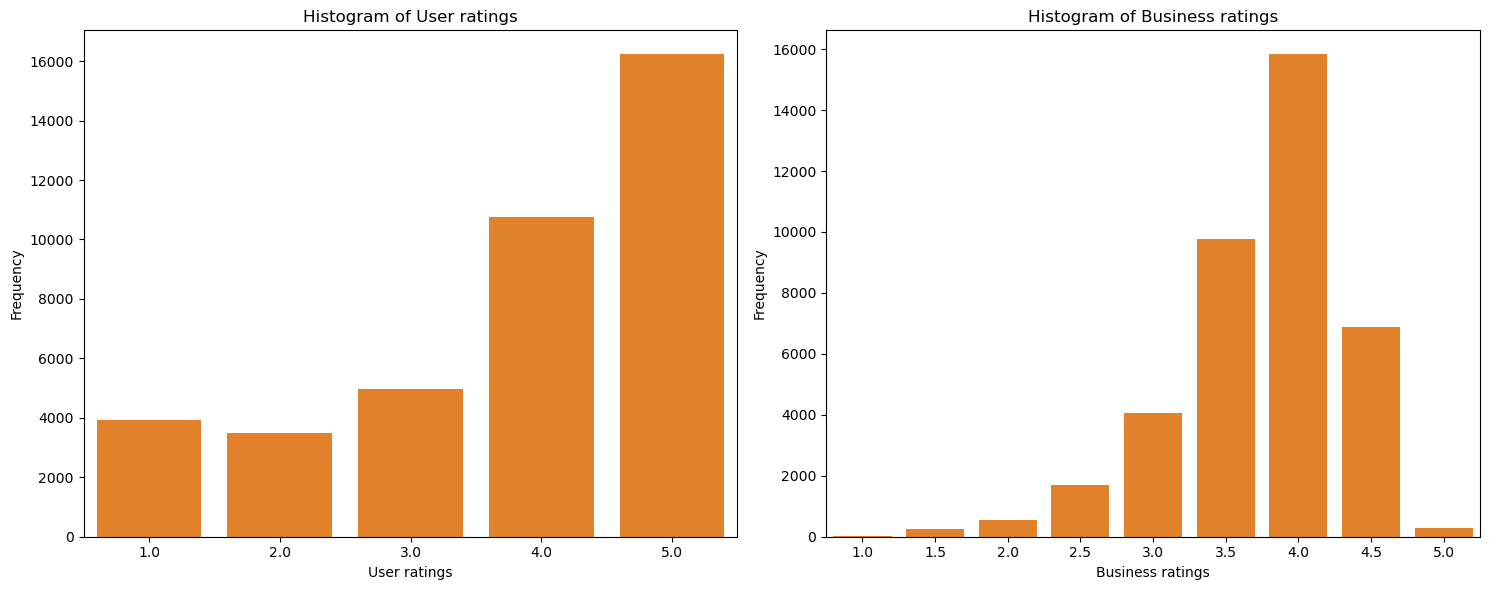

In [40]:
# Assuming you have a DataFrame named 'df' and two numerical columns 'column1' and 'column2'
column1 = 'rating'
column2 = 'b/s_rating'

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Adjust the figsize as needed

# Create histograms for column1 and column2
 
sns.countplot(data=data, x=column1 ,ax=axes[0] , color='tab:orange')
# Adjust the number of bins as needed
axes[0].set_xlabel("User ratings")
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Histogram of User ratings')

sns.countplot(data=data, x=column2 ,ax=axes[1] ,color='tab:orange')
  # Adjust the number of bins as needed
axes[1].set_xlabel("Business ratings")
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Histogram of Business ratings')
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [41]:
df_1 = data[['rating', 'b/s_rating', 'review_count']]
df_1.corr()

,rating,b/s_rating,review_count
rating,1.000000,0.409173,0.106111
b/s_rating,0.409173,1.000000,0.237139
review_count,0.106111,0.237139,1.000000


**Correlation between Rating and B/S Rating**

Correlation Value: 0.409173 The positive correlation coefficient of approximately 0.41 suggests a moderate positive relationship between the rating of a restaurant or service and its B/S Rating. In other words, as the rating of a business increases, its B/S Rating tends to increase as well. Businesses with higher individual ratings are likely to have a higher overall rating based on user reviews.

**Correlation between Rating and Review Count**

Correlation Value: 0.106111 The correlation coefficient of about 0.11 indicates a weak positive correlation between the rating of a restaurant or service and its review count.This suggests that businesses with higher ratings may have slightly more reviews, but the relationship is not particularly strong.

**Correlation between B/S Rating and Review Count**

Correlation Value: 0.237139 The correlation coefficient of approximately 0.24 suggests a moderate positive correlation between the B/S Rating of a business and its review count. This implies that businesses with higher B/S Ratings tend to have more user reviews. Customers are more likely to review businesses with higher overall ratings, contributing to the positive correlation.

#### 2.Distribution of Categories
1) What are the most prevalent restaurant categories and how does the distribution of these categories impact the restaurant landscape in terms of user preferences and choices?

c:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


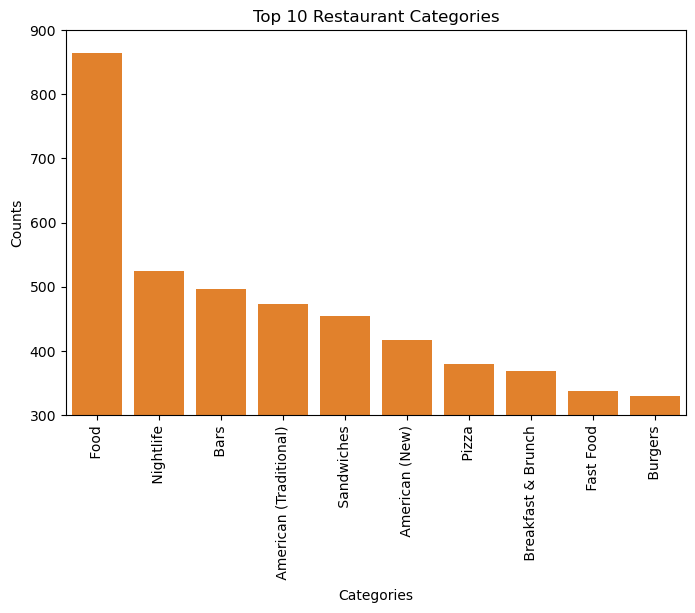

In [42]:

# list of all categories
categories=[ cat for category in data.drop_duplicates('business_id').categories for cat in category.split(',')]
# list of unique categories 
categories=collections.Counter(categories)
#picking top 20 categories
common=categories.most_common(12)
# ploting
fig, ax=plt.subplots(figsize=(8,5))
x=[ i[0] for i in common[2:]]
y=[i[1] for i in common[2:]]
sns.barplot(x=x, y=y, color='tab:orange', ax=ax)
ax.set_xlabel("Categories")
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Counts")
ax.set_ylim([300,900])
ax.set_title("Top 10 Restaurant Categories");
plt.show()


#### 3 Distribution of Restaurants across the citties and states

1.CITTIES


c:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


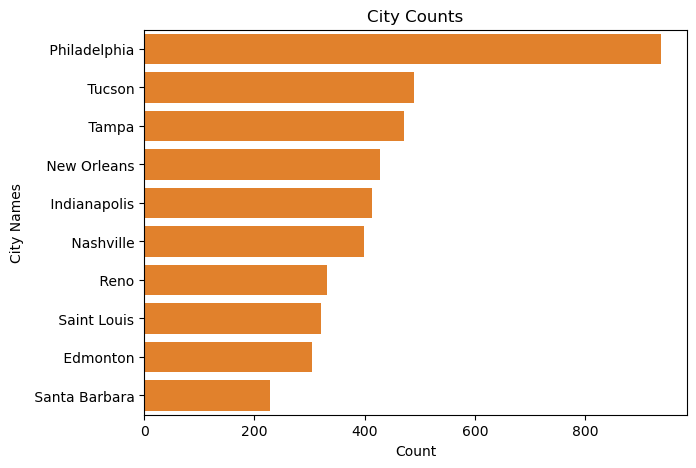

In [43]:
# extract the location column and drop duplicate business entries
location= restaurant_df.drop_duplicates('business_id')[['location']]
# split the location string to extract the city part, removing city from each entry
city=location.location.apply(lambda x: x.split(',')[1].replace("City:",'')) 
# count the occurrences of each city and selected the top 10 cities
city=collections.Counter(city)
city=city.most_common(10)
# extract the city names and their respective counts
y=[i[0] for i in city]
x=[i[1] for i in city]
# created a barplot to visualize the city counts
fig, ax=plt.subplots(figsize=(7,5))
sns.barplot( y=y, x=x, color='tab:orange')
ax.set_ylabel("City Names")
ax.set_xlabel("Count")
ax.set_title("City Counts");


From the analysis above its so clear that philadephia has the highest number of restaurantst city. Following, but not as closely, is Tampa, indicating a notable restaurant presence. In contrast, the cities of Edmonton and Santa Barbara have fewer restaurants, making them less common in this dataset.

2.STATES

c:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


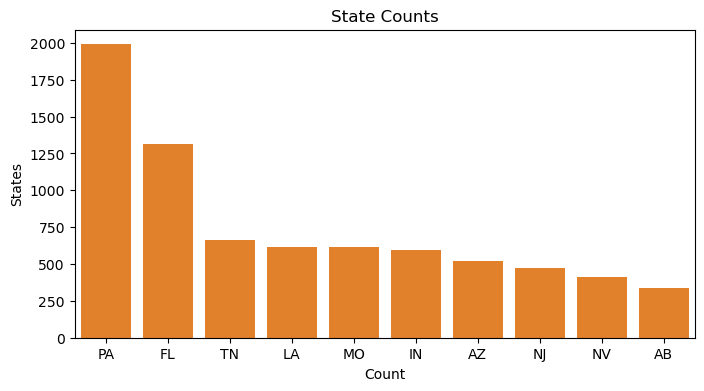

In [44]:
# extract the location column and split it to obtain the state part
states=location.location.apply(lambda x: x.split(',')[0].replace("State:",'')) 
# count the occurrences of each state and select the top 10 states
states=collections.Counter(states)
states=states.most_common(10)
# extract the state names and their respective counts for visualization
y=[i[0] for i in states]
x=[i[1] for i in states]
# created a barplot to visualize the state counts
fig, ax=plt.subplots(figsize=(8,4))
sns.barplot( y=x,x=y , color='tab:orange')
ax.set_ylabel("States")
ax.set_xlabel("Count")
ax.set_title("State Counts");

From the analysis above it is so clear  that Philadelphia has the highest number of restaurants in the dataset. Following, but not as closely, is Florida, indicating a notable presence of restaurants in that state. In contrast, Alberta and Nevada have fewer restaurants, making them less common in this dataset.

### Popular Restaurants

Analyzing and highlighting the most popular restaurants is essential because it allows us to recognize the establishments that have garnered significant attention and interest from customers. This information will be valuable for consumers seeking highly-rated dining experiences.

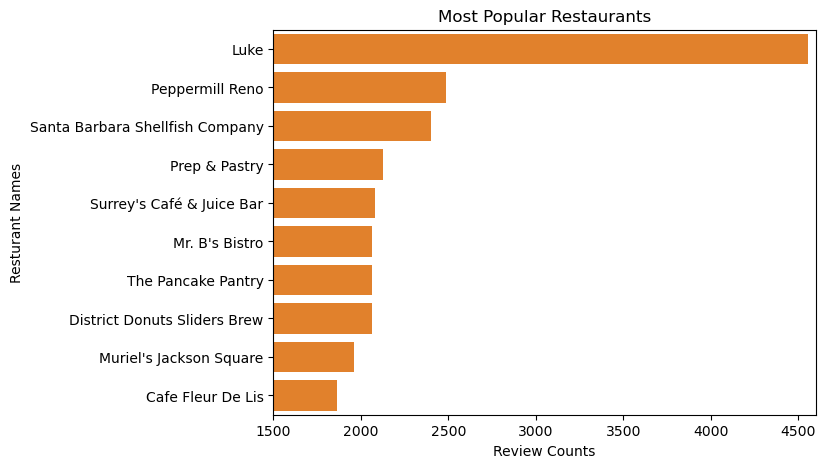

In [45]:
# most popular restaurants

index=restaurant_df.drop_duplicates(subset='business_id').sort_values(by=['review_count','b/s_rating'],ascending=False)[:10].index

fig, ax=plt.subplots(figsize=(7,5))
sns.barplot(data=restaurant_df.loc[index], x="review_count", y='name', color='tab:orange')
ax.set_ylabel("Resturant Names")
ax.set_xlabel("Review Counts")
ax.set_xlim([1500,4600])
ax.set_title("Most Popular Restaurants");


The output highlights the review counts for the different restaurants in descending order. At the top is Luke , signifying that it has received a substantial amount of customer feedback. Following closely is the Santa Barbara Shellfish Company , demonstrating a strong presence and popularity among diners. Cafe Fleur De Lis is the last on the list. These review counts offer insights into the popularity and customer engagement of these respective restaurants.

To visualize the relationship between business rating and the number of reviews more effectively, we will be creating a 2D histogram or a hexbin plot. These plots provide a better representation of the density and concentration of data points.

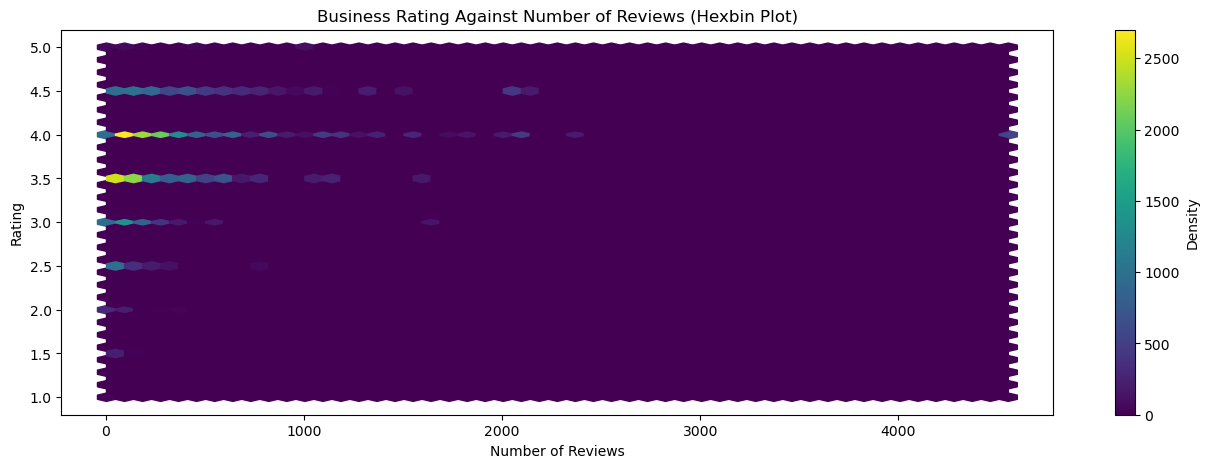

In [46]:
fig, ax = plt.subplots(figsize=(16,5))

# Create a hexbin plot
hb = ax.hexbin(data['review_count'], data['b/s_rating'], gridsize=50, cmap='viridis')

ax.set_xlabel("Number of Reviews")
ax.set_ylabel("Rating")
ax.set_title('Business Rating Against Number of Reviews (Hexbin Plot)')

# Add a colorbar to indicate the density of points
cb = plt.colorbar(hb)
cb.set_label('Density')

> From the graph, we see that, the number of reviews are increasing with increase on the restaurant rating. This means that restaurant with hight star ratings tend to have many reviews for customers.

### Review Word Cloud Analysis

To create a word cloud visualization that highlights the most frequent words found in review texts column. By filtering and analyzing the text of positive reviews, the word cloud offers an intuitive and visually appealing way to identify the key themes and frequently mentioned aspects that contribute to a positive customer experience. This visualization provides valuable insights into the factors that most positively influence customer satisfaction, aiding in the understanding of what makes certain businesses successful and well-reviewed on Yelp.

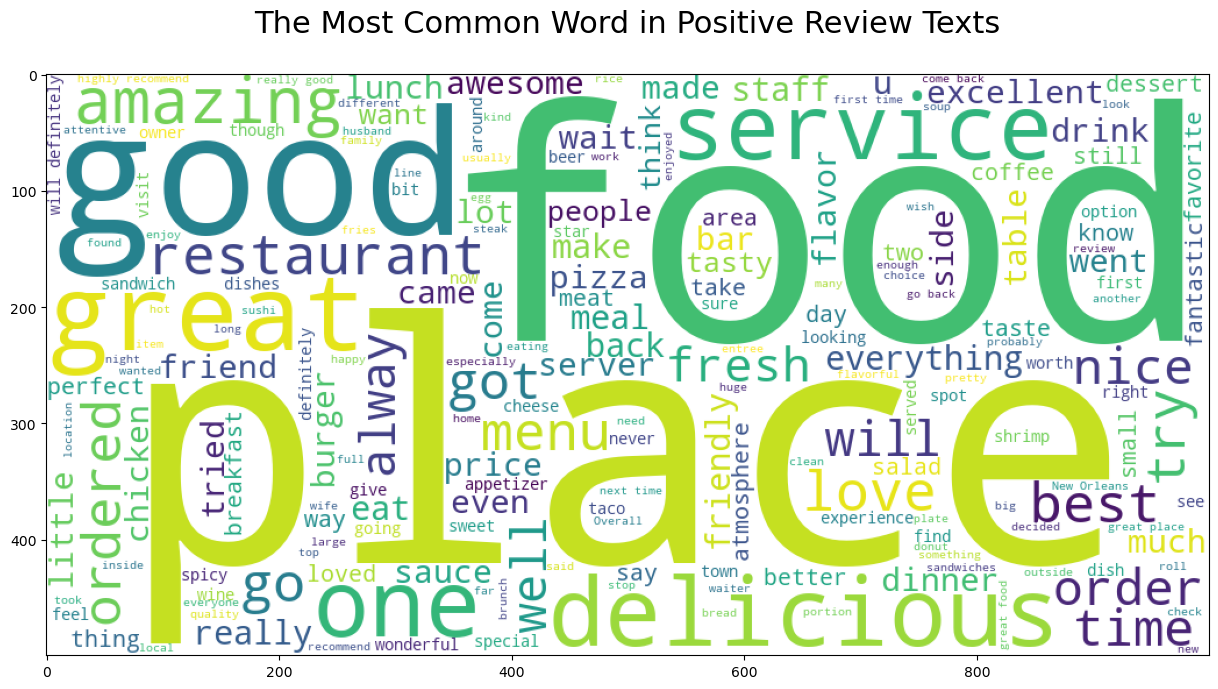

In [48]:
# creating a word count plot for the positive reviews

# selecting only positive reviews is reviews with 4 and above ratings
df=data.loc[ (data['rating']>=4)& (data['b/s_rating']>=4)] 

# creating the plot figure
plt.figure(figsize=(15,15))            

plt.title('The Most Common Word in Positive Review Texts\n', fontsize=22)  # setting plot title

# creating the plot on only the most 200 words and setting the plot size
wc = WordCloud(max_words=200, min_font_size=10,height=500,width=1000,background_color="white")\
        .generate(' '.join(df['text'])) #create a WordCloud using the text review column

plt.imshow(wc);

The word cloud visually represents the most common words found in the positive review texts, where the size of each word in the cloud corresponds to its frequency in the reviews. This provides an overview of the key terms and themes in positive reviews.
> Therefore from the plot above, the most occurring words in the positive reviews are words like , **good, food, place , great , delicious , great , service , amazing , best,..etc**. 

To create a word cloud visualization that highlights the most frequently occurring words in negative review texts from the Yelp dataset. By filtering and analyzing the text of negative reviews, the word cloud offers a visual representation of the common themes and frequently mentioned issues that contribute to a negative customer experience.

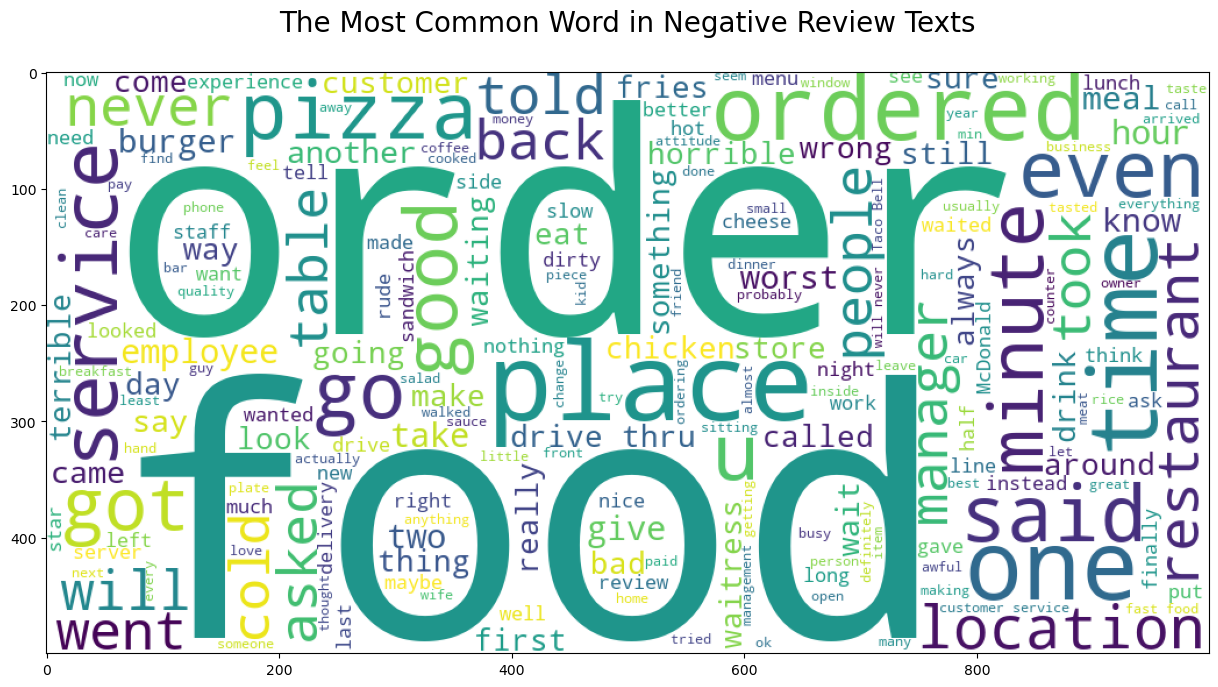

In [49]:
# creating a word count plot for the positive reviews

# selecting only negative reviews i.e reviews with 2 and below ratings
df=data.loc[ (data['rating']<=2)& (data['b/s_rating']<=2)]
plt.figure(figsize=(15,15))

# creating the plot figure
plt.title('The Most Common Word in Negative Review Texts\n', fontsize=20)


# creating the plot on only the most 200 words and setting the plot size
wc = WordCloud(max_words=200,height=500,width=1000,background_color="white")\
        .generate(' '.join(df['text']))    #create a WordCloud using the text review column

plt.imshow(wc);

This visualization provides valuable insights into the factors that may lead to poor reviews, helping to identify areas of improvement for businesses and assisting in understanding the aspects that negatively impact customer satisfaction on Yelp.
> Therefore from the plot above, the most occurring words in the negative reviews are words like, **minute , food, place , ordered, pizza, terrible, time, service, said ..etc**, these words are attributed to dissatisfied customers and issuance of bad /poor ratings to restaurants. When such words are encountered there should be further investigation of the business service delivery for improvements.

### Interactive Map Visualization with Folium

The idea is to write a code that generates an interactive map using Folium, a Python library for creating leaflet maps. The map is centered at a specific latitude and longitude, which is determined by the first entry in the dataset. It then proceeds to populate the map with markers for selected businesses.

In [47]:
# Set up center latitude and longitude
center_lat = restaurant_df['latitude'][0]
center_long = restaurant_df['longitude'][0]

# Initialize map with center lat and long
map_ =folium.Map([center_lat,center_long], zoom_start=5)

# Adjust this limit to see more or fewer businesses
limit=1000

for index in range(limit):
    # Extract information about business
    lat = restaurant_df.loc[index,'latitude']
    long = restaurant_df.loc[index,'longitude']
    name = restaurant_df.loc[index,'name']
    rating = restaurant_df.loc[index,'b/s_rating']
    location = restaurant_df.loc[index,'location']
    details = "{}\nStars: {} {}".format(name,rating,location)
    
    # Create popup with relevant details
    popup = folium.Popup(details,parse_html=True)
    
    # Create marker with relevant lat/long and popup
    marker = folium.Marker(location=[lat,long], popup=popup)
    
    marker.add_to(map_)
    
map_

The result is an interactive map with markers representing businesses. When you click on a marker, a popup appears with details about the business, such as its name, rating, and location. This visualization provides a spatial perspective on the distribution of businesses in the dataset.

## Modelling

In this section we will create a recommendation system using the datasets to solve our main problem.
There are different types of recomentation models, in this project we will focus on three types of recommentation systems

* 1. Content-Based Recommender systems
* 2. Collaborative Filtering Systems
* 3. Deep Neural Networks

Now, in each of these categories we will compare the different models and see which ones perform best. For validation and comparison we will use the RMSE (root mean squared error) metric, that is how far is the prediction from the true value.

### Sentiment Analysis

Now the next step is to perform some text preprocessing steps which include:

- Feature engineering : further feature engineering of the columns to meet the required specifications for analysis eg aggregating text reviews, creating new columns from the existing columns .. etc
- Removal of Punctuations and Removal of Stopwords - we'll make use of the **RegexpTokenizer()** method
-  Stemming - reducing words to their root meaning , we'll use the **SnowballStemmer()** method
- Word-Vectorization - splitting text data into a vector of individual words for further and easier nlp analysis, we'll make use of the **TidfVectorizer()** method that vectorizes text data and calculates their respective Term Frequency - Inverse Document Frequency (TI-IDF) values.

Now let’s perform the above text preprocessing steps on the data:

#### Feature Engineering 
 
This feature engineering step helps prepare your data for analysis and modeling by selecting and transforming the most relevant attributes, which can lead to more effective modeling and improved insights for our project.
> We'll start by creating a new **review column** that aggregates all the text reviews pertaining a single restaurant from all the users into one text.


In [50]:
# Create a function that aggregates/combines all the extra reviews made to a particular restaurant into one text

def new_df(data):
    """
    This function takes in a dataframes and groups it by business_id column then combines all the text values in the
    text column into one big text then assigns it to the review column
    
    """
    # drop duplicates based on business_id and reset the index
    df = data.drop_duplicates('business_id').reset_index(drop=True)
    
    # loop through unique business_id values
    for id in data.business_id.unique():
    # extract text for each unique business_id and explode it into separate rows
        text = data.loc[data.business_id == id, 'text'].explode(ignore_index=True)
    # join the exploded text into a single string
        text = ' '.join(text)
        
    # assign the concatenated text to the reviews column for the corresponding business_id
        df.loc[data.business_id == id, 'reviews'] = text
    
    return df

# call the function and create the new df
df = new_df(data)
df.head()  

,user_id,business_id,rating,text,name,latitude,longitude,b/s_rating,review_count,attributes,categories,hours,location,price,reviews
0,1,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,40.210196,-75.223639,3.0,169,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...","State:PA, City:North Wales, Address:1460 Bethl...",0,"If you decide to eat here, just be aware it is..."
1,3,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,Kettle Restaurant,32.207233,-110.980864,3.5,47,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",Not-Available,"State:AZ, City:Tucson, Address:748 W Starr Pas...",0,Family diner. Had the buffet. Eclectic assortm...
2,4,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",Zaika,40.079848,-75.025080,4.0,181,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...","State:PA, City:Philadelphia, Address:2481 Gran...",0,"Wow! Yummy, different, delicious. Our favo..."
3,5,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,Melt,29.962102,-90.087958,4.0,32,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...","State:LA, City:New Orleans, Address:2549 Banks...",0,Cute interior and owner (?) gave us tour of up...
4,6,04UD14gamNjLY0IDYVhHJg,1.0,I am a long term frequent customer of this est...,Dmitri's,39.938013,-75.148131,4.0,273,"{'BusinessParking': '{'garage': False, 'street...","Mediterranean, Restaurants, Seafood, Greek","{'Wednesday': '17:30-21:0', 'Thursday': '17:30...","State:PA, City:Philadelphia, Address:795 S 3rd...",0,I am a long term frequent customer of this est...


> We'll the create a new column called **attributes_true** by only extracting the true business attributes contained in the attributes column that has dictionary-like entries

In [59]:
def decompress(x):
    """
    The function takes in a dictionary and returns only the keys that have their values not being False   
    """
      
    list_ = []
    # iterate through the key-value pairs in the dictionary
    for key, val in x.items():
        # check if the key is in the specified categories and if the value is not "None"
        if (key in ['Ambience', 'GoodForMeal', 'BusinessParking']) and (val != "None"):
            # if conditions are met, further iterate through sub-dictionary
            if isinstance(val, dict):
                for key_, val_ in val.items():
                    # if the sub-dictionary value is true, append it to the list
                    if val_:
                        list_.append(f'{key}_{key_}')
        else:
            # if the value is not false, append the key to the list
            if val != 'False' and val is not False:
                list_.append(key)
    
    # join the list of selected attribute names into a space-separated string
    return " ".join(list_)

# create a new column 'attributes_true' in the df by applying the decompress function
# include a condition to handle cases where attributes is 'Not-Available'
df['attributes_true'] = df.attributes.apply(lambda x: decompress(x) if x != 'Not-Available' else ' ')

In [61]:
# confirming if the newly created column has performed as expected
print("Before:")
print(df.attributes[0])
print('\n After:')
print(df['attributes_true'][0])
    # Print the result for the first row of 'attributes'

Before:
{'NoiseLevel': "u'average'", 'HasTV': 'False', 'RestaurantsAttire': "'casual'", 'BikeParking': 'False', 'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}", 'WiFi': "'free'", 'DogsAllowed': 'False', 'Alcohol': "'none'", 'BusinessAcceptsCreditCards': 'True', 'RestaurantsGoodForGroups': 'True', 'RestaurantsPriceRange2': '2', 'RestaurantsReservations': 'False', 'WheelchairAccessible': 'True', 'BusinessAcceptsBitcoin': 'False', 'RestaurantsTableService': 'True', 'GoodForKids': 'True', 'Caters': 'False', 'HappyHour': 'False', 'RestaurantsDelivery': 'True', 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'brunch': True, 'breakfast': True}", 'OutdoorSeating': 'True', 'RestaurantsTakeOut': 'True', 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"}

 After:
NoiseLevel Restau

>From the above output we can see that the function has only retrieved keys that have values not equal to 'False'

> - We will then merge the **attributes_true, categories, reviews** columns into one large text for each unique business and assign to a new column **details**

In [64]:
# merging different columns to form one column of text 
df['details']=df[['attributes_true','categories','reviews']].apply(lambda x: ''.join(x), axis=1)

# previewing the first row value in the new column
df.details[0]

"NoiseLevel RestaurantsAttire WiFi Alcohol BusinessAcceptsCreditCards RestaurantsGoodForGroups RestaurantsPriceRange2 WheelchairAccessible RestaurantsTableService GoodForKids RestaurantsDelivery OutdoorSeating RestaurantsTakeOutRestaurants, Breakfast & Brunch, Food, Juice Bars & Smoothies, American (New), Coffee & Tea, SandwichesIf you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker. This is the second time we tried turning point at this location. The first time we had a long wait for food after ordering, this time we had an even long

> After creating our desired column **details** , w'll then drop the columns that will not be useful onwards

In [65]:
# dropping columns
df.drop(columns=['attributes_true','reviews'], inplace=True)

From the text example above we can see that the column text contains many symbols, punctuations and stopwords, next we shall remove the symbols and tokenize the column into a bag of words. These reasons serve to prepare text data for various text analysis and NLP tasks. It tokenizes the text, applies stemming, and standardizes the text for downstream processing, making it easier to analyze and extract meaningful information from the text.

In [67]:
# first create a pattern that strips all the non-word characters from words during tokenization
pattern =r"(?u)\b\w\w+\b"

# instantiate the tokenizer
tokenizer = RegexpTokenizer(pattern)

# instantiating the stemmer
stemmer = SnowballStemmer(language="english")

# creating a function to tokenize and stem words
def stem_and_tokenize(list_):
    tokens = tokenizer.tokenize(list_)
    return [stemmer.stem(token) for token in tokens]

After instantiating the tokenizer and stemmer we then calculate the text frequency-inverse document frequency values using the  **TfidfVectorizer()** method. Calculating TF-IDF values is a crucial step in preparing text data for analysis and transforming it into a format suitable for many NLP and text mining tasks. It helps convert unstructured text into structured numerical data that can be used for various analytical and machine learning purposes.

In [68]:
# instantiating the stop words
stopwords=stopwords.words('english')
# stemming the stopwords for uniformity while removing stopwords
stopwords=[ stemmer.stem(i) for i in stopwords]


tfidf = TfidfVectorizer( max_features=200 , 
                        stop_words=stopwords,
                        tokenizer= stem_and_tokenize
#                         ngram_range=(1, 2), 
#                         min_df=0, 
                        )


# fitting and transforming the details column to extract the top 200 features
tfidf_matrix=tfidf.fit_transform(df['details'])

# previewing the tfidf matrix
pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=tfidf.get_feature_names_out()).head()

c:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,also,alway,amaz,anoth,appet,area,around,ask,atmospher,attent,...,walk,want,way,well,went,wine,wonder,work,worth,would
0,0.030917,0.000000,0.033784,0.148950,0.000000,0.071060,0.00000,0.067906,0.000000,0.040761,...,0.000000,0.032251,0.068911,0.031813,0.033654,0.000000,0.000000,0.000000,0.037926,0.059517
1,0.075967,0.000000,0.000000,0.000000,0.000000,0.043651,0.00000,0.041713,0.046024,0.100155,...,0.046288,0.000000,0.042331,0.039084,0.041346,0.000000,0.000000,0.091133,0.000000,0.146242
2,0.030903,0.066009,0.067537,0.018610,0.022747,0.088784,0.05351,0.000000,0.018722,0.020371,...,0.000000,0.064471,0.017220,0.079496,0.084095,0.026438,0.020262,0.055608,0.056862,0.074362
3,0.061690,0.000000,0.000000,0.000000,0.000000,0.070894,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.068750,0.063478,0.067151,0.316666,0.000000,0.000000,0.000000,0.059378
4,0.046791,0.266525,0.068173,0.037571,0.091846,0.000000,0.00000,0.034257,0.000000,0.020563,...,0.000000,0.032539,0.034764,0.016049,0.050933,0.053375,0.102267,0.018711,0.038265,0.090075


The code is configuring and using a TF-IDF vectorizer to convert text data into a numerical representation that captures word importance, while stemming stopwords for uniformity. The warning message is related to an unused parameter and does not affect the execution of the code.

In [69]:
# creating a matrix of the cosine similarities of the various rows based on the tidf scores
cosine_similarity=cosine_similarity(tfidf_matrix)
print("shape: ",cosine_similarity.shape)

# viewing the first column
cosine_similarity[0]

shape:  (3720, 3720)


array([1.        , 0.56019903, 0.52164205, ..., 0.50178735, 0.59844529,
       0.4746701 ])

The code is calculating the cosine similarity between the rows of the TF-IDF matrix (tfidf_matrix). The cosine similarity is a measure of similarity between two non-zero vectors in an inner product space, often used for text document similarity calculations. In this case, it's used to measure the similarity between the 'details' text descriptions of different businesses based on their TF-IDF scores.

> We will then pickle our desired data and cosine matrix for deployment

In [70]:
# saving our data for deployment
pickle.dump(tfidf_matrix, open('./data/tfidf_matrix.pkl', 'wb'))
pickle.dump(cosine_similarity, open('./data/cosine_similarity.pkl', 'wb'))
pickle.dump(df, open('./data/data.pkl', 'wb'))
print("Files saved...")

Files saved...


In [71]:
with open('./data/cosine_similarity.pkl', 'rb') as file:
    cosine_similarity=pickle.load(file)
    
with open('./data/data.pkl', 'rb') as file:
    df=pickle.load(file)

### Content-Based Model

Using the cosine similarity matrix we will now create a content-based recommendation system that offers recommendations to users based on the restaurant names or text words representing the specifications of their desired restaurant and attributes.


> We use the cosine similarity matrix to compare similarities between different restaurants and the customer's preferences, then pick the top n similar restaurants to recommend based on his/her input. 

In [72]:
# creating a folium_map function that displays restaurant lovations

def folium_map(data):
    """
    The function takes in a dataframe and using the latitude and longitude columns displays a map showing the locations of 
    all the restaurants available in the input data
    """
    # reseting the index in the input dataframe
    dff=data.reset_index(drop=True)


# Set up center latitude and longitude
    center_lat = dff['latitude'][0]
    center_long = dff['longitude'][0]

# Initialize map with center lat and long
    map_ =folium.Map([center_lat,center_long], zoom_start=7)

# Adjust this limit to see more or fewer businesses
    limit=dff.shape[0]
    print(f"{limit-1} Restaurant Locations")
    for index in range(limit-1):
        # Extract information about business
        lat = dff.loc[index,'latitude']
        long = dff.loc[index,'longitude']
        name = dff.loc[index,'name']
        rating = dff.loc[index,'b/s_rating']
        location = dff.loc[index,'location']
        details = "{}\nStars: {} {}".format(name,rating,location)

# Create popup with relevant details
        popup = folium.Popup(details,parse_html=True)

# Create marker with relevant lat/long and popup
        marker = folium.Marker(location=[lat,long], popup=popup)

        marker.add_to(map_)

    return display(map_)  # returning a map display

In [73]:
folium_map(data=df.loc[:10])

10 Restaurant Locations


The content_based function uses content-based recommendation techniques to provide restaurant recommendations based on user input preferences, restaurant names, or user-defined text. The recommendations can be filtered by minimum rating and location and are visually presented on an interactive map if specified.

In [74]:
def content_based(df=df, name:str= None , rating:int =1, num:int=5, text: str=None, location:str = None):
    """
    The function takes the following input;
    
    df: DataFrame - a dataframe containing unique resturants
    name: str - name of restaurant to recommend similar restaurants
    num:int - number of restaurants to recommend
    location: string - preferred location
    rating: string - preferred rating of restaurant
    text: - User preferences inform of text
    
    Then based on the input parameters offers similar restaurants according to the input parameters to users
    """
    
    if name:
        index_=df.loc[df.name== name].index[0]                          # find the index of the input name
        sim=list(enumerate(cosine_similarity[index_]))                  # extract similarity vector of that name index
        sim=sorted(sim, key=lambda x: x[1], reverse=True)[1:num+1]      # arrange the vector values in ascending order
        indices= [i[0] for i in sim]                                    # Extract the indices of the top high scores
        print(f"Top {num} Restaurants Like [{name}]")
        
        # if the location parameter is passed then the dataframe is filtered based on the input location
        if location:                                                
            df=df.loc[ (df['b/s_rating']>=rating) & ( df.location.str.contains(location))]
            folium_map(df)
        else: 
            df= df.loc[ (df['b/s_rating']>=rating) ] 
        # filtering the data based on the selected indices    
        df=df.loc[indices,('name','b/s_rating','review_count','location')].sort_values('b/s_rating', ascending=False)
        return  df.reset_index(drop=True)
    
    # if the name is None then switch to other parameters
    else:
        # if the text has a passed input values then this if statement runs            
        if text: 
                text=text.lower()                                           # converting the text into lowercase
                tokens=stem_and_tokenize(text)                              # tokenizing and stemming the words
                tokens=[ word for word in tokens if word not in stopwords]  # removing stopwords
                text_set=set(tokens)                                        # taking only unique words
                
                if location: # using entered location to filter the data
                    df=df.loc[ (df.location.str.contains(location)) & (df['b/s_rating']>=rating)].reset_index(drop=True)

                vectors=[] # creating an emplty list to append the intersection values
                for words in df.details:                                     # looping over the text in the details column
                    words=words.lower()                                      # lowering the text
                    words=stem_and_tokenize(text)                            # tokenizing and stemming the words
                    words=[ word for word in tokens if word not in stopwords] # removing stopwords
                    words=set(words)                                         # taking only unique words
                    vector=text_set.intersection(words)                      # checking for intersection with entered text 
                    vectors.append(len(vector))                              # appending value to vectors list
                    
                vectors=sorted(list(enumerate(vectors)), key= lambda x: x[1], reverse=True)[:num] # sorting the list in desc
                indices= [i[0] for i in vectors]                                         # selecting indices of top values
                print(f"Top {num} Best Restaurants Based on entered text:")
                # using the indices fileter the dataframe 
                df=df.loc[indices].sort_values(by=['b/s_rating','review_count'],ascending=False)
                if location: folium_map(df)                                   # calling the folim_map of the selected values
                return df[['name','b/s_rating','review_count','location']].reset_index(drop=True) # offering recommendations
        
        # the if only location is entered as a parameter then the top businesses in that location are recommended
        if location:
            df=df.loc[ df.location.str.contains(location)& (df['b/s_rating']>=rating)] #filtering dataframe
            df=df.sort_values(['review_count','b/s_rating'])[:num]     # sorting in descending order
            folium_map(data=df)
            return df[['name','b/s_rating','review_count','location']].reset_index(drop=True) # offering recommendations
         
        # if both the name, text and location are None the most popular restaurants are recommended
        else:                
            df=df.loc[data['b/s_rating']>=rating].sort_values(by=['review_count','b/s_rating'],ascending=False)[:num]
            if location: folium_map(data=df)
            print("Most Popular Restaurants")
            return df[['name','b/s_rating','review_count','location']].reset_index(drop=True)
    
    

In [75]:
# running the recommender on default parameters
content_based()

Most Popular Restaurants


,name,b/s_rating,review_count,location
0,Luke,4.0,4554,"State:LA, City:New Orleans, Address:333 Saint ..."
1,Santa Barbara Shellfish Company,4.0,2404,"State:CA, City:Santa Barbara, Address:230 Stea..."
2,Prep & Pastry,4.5,2126,"State:AZ, City:Tucson, Address:2660 N Campbell..."
3,Surrey's Café & Juice Bar,4.5,2084,"State:LA, City:New Orleans, Address:1418 Magaz..."
4,Mr. B's Bistro,4.0,2064,"State:LA, City:New Orleans, Address:201 Royal St"


In [76]:
# offering recommendations based on a specific location
content_based(location='Philadelphia')

4 Restaurant Locations


,name,b/s_rating,review_count,location
0,Papa John's Pizza,1.5,5,"State:PA, City:Philadelphia, Address:1555 Wads..."
1,New Napoli Famous Pizza,2.0,5,"State:PA, City:Philadelphia, Address:911 Tyson..."
2,Amato's Deli Restaurant,2.5,5,"State:PA, City:Philadelphia, Address:3000 S Sy..."
3,Venuto's Old World Pizza,3.0,5,"State:PA, City:Philadelphia, Address:6024 Ridg..."
4,Philly Dawgz,4.0,5,"State:PA, City:Philadelphia, Address:3240 N Br..."


In [77]:
# recommending similar restaurants to the entered name
content_based( name="Backspace Bar & Kitchen")

Top 5 Restaurants Like [Backspace Bar & Kitchen]


,name,b/s_rating,review_count,location
0,Black Palm Restaurant,4.5,11,"State:FL, City:St. Petersburg, Address:1700 Pa..."
1,Independence Brew Pub,4.5,5,"State:PA, City:Philadelphia, Address:1150 Filb..."
2,Union Station Pub & Grill,4.0,9,"State:LA, City:New Orleans, Address:735 St Jos..."
3,Fellini Cafe of Media,4.0,508,"State:PA, City:Media, Address:106 W State St"
4,Dimaggio's Restaurant,2.5,12,"State:AB, City:Sherwood Park, Address:"


In [78]:
# recommending restaurants with attributes in the entered text
content_based( text="I want a clean restaurant with good desert and parking space and a romantic environment")

Top 5 Best Restaurants Based on entered text:


,name,b/s_rating,review_count,location
0,Dmitri's,4.0,273,"State:PA, City:Philadelphia, Address:795 S 3rd..."
1,Zaika,4.0,181,"State:PA, City:Philadelphia, Address:2481 Gran..."
2,Melt,4.0,32,"State:LA, City:New Orleans, Address:2549 Banks..."
3,Kettle Restaurant,3.5,47,"State:AZ, City:Tucson, Address:748 W Starr Pas..."
4,Turning Point of North Wales,3.0,169,"State:PA, City:North Wales, Address:1460 Bethl..."


In [79]:
# recommending restaurants with attributes in the entered text
content_based(rating=4, location="PA",num=10,\
        text="restaurant with crabs and sushi and a romantic setting and parking space also the food should be delicious")

Top 10 Best Restaurants Based on entered text:
9 Restaurant Locations


,name,b/s_rating,review_count,location
0,Thai Place Restaurant,4.5,222,"State:PA, City:Phoenixville, Address:700 Nutt ..."
1,Chase's Hop Shop,4.5,116,"State:PA, City:Philadelphia, Address:7235 Risi..."
2,Village Whiskey,4.0,1553,"State:PA, City:Philadelphia, Address:118 S 20t..."
3,Limoncello Ristorante & Caterers,4.0,483,"State:PA, City:West Chester, Address:9 N Walnu..."
4,Dmitri's,4.0,273,"State:PA, City:Philadelphia, Address:795 S 3rd..."
5,Termini Bros Bakery,4.0,263,"State:PA, City:Philadelphia, Address:12th St &..."
6,Good Karma Cafe,4.0,249,"State:PA, City:Philadelphia, Address:928 Pine St"
7,Zaika,4.0,181,"State:PA, City:Philadelphia, Address:2481 Gran..."
8,Portobello Cafe,4.0,137,"State:PA, City:Eddystone, Address:1423 Chester..."
9,The Coventry Deli,4.0,65,"State:PA, City:Philadelphia, Address:2000 Mark..."


### Collaborative filtering Models
#### Neighborhood-Based Models

Here the tasks related to building a collaborative filtering recommendation system using the Surprise library are undertaken for collaborative filtering by selecting the relevant columns, importing the Surprise library, initializing a Reader object to specify the data format, and then loading the data into a Surprise Dataset object for further analysis and model building.

> Now, we will compare the different neighborhood-based models and see which ones perform best based on the RMSE metric, then compare the neighborhood-based model with the model-based models and pick the best model.


In [80]:
 #selecting specific columns that are relevant for collaborative filtering models
new_df = data[['user_id', 'business_id', 'rating']]

# using Reader() from surprise module to convert dataframe into surprise dataformat
# instantiating a readerobject
reader = Reader()

# using the reader to read the trainset
data_2 = Dataset.load_from_df(new_df,reader)

dataset = data_2.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of Restaurants: ', dataset.n_items)

Number of users:  34497 

Number of Restaurants:  3720


> Now, we will compare the different neighborhood-based models and see which ones perform best based on the RMSE metric. Since the number of users is more than the number of items, we are going to use an item-based similarity system.

In [82]:
# create the first neighborhood model based on the 30 most similar users
# using pearson similarity metric
knn=KNNBasic(k=10,sim_options={'name':'pearson', 'user_based':False})

# using the cross_validate() to fit the model on 5 folds
results=cross_validate(knn, data_2 , cv=5, n_jobs=-1)

#printng the valuation test score
for values in results.items():
    print(values)
print("-------------------------")
print("Mean RMSE: ",results['test_rmse'].mean())      #calculating mean RMSE of the first model

('test_rmse', array([1.33545177, 1.3158083 , 1.3158421 , 1.32421222, 1.32195836]))
('test_mae', array([1.08850332, 1.08004492, 1.0780903 , 1.07814416, 1.0841424 ]))
('fit_time', (0.7380566596984863, 0.7313053607940674, 0.7308943271636963, 0.719656229019165, 0.44710803031921387))
('test_time', (0.17950987815856934, 0.18552088737487793, 0.19740605354309082, 0.1561908721923828, 0.14032602310180664))
-------------------------
Mean RMSE:  1.3226545501848375


The first KNN model acheived an rmse of 1.32, meaning its 1.32 units off every prediction,  we will then run the same KNN model on **Cosne similarity** metric to see if it performs better.

In [83]:
# create the second neighborhood model based on the 30 most similar users
# using cosine similarity metric
knn=KNNBasic(k=10,sim_options={'name':"cosine", 'user_based':False})

# using the cross_validate() to fit the model on 5 folds
results=cross_validate(knn, data_2 , cv=5, n_jobs=-1)

#printng the valuation test scores
for values in results.items():
    print(values)
print("-------------------------")
print("Mean RMSE: ",results['test_rmse'].mean())    #calculating mean RMSE of the second model

('test_rmse', array([1.33837899, 1.31618194, 1.31941863, 1.33914297, 1.32444316]))
('test_mae', array([1.0891399 , 1.06855354, 1.08109461, 1.09861483, 1.08481718]))
('fit_time', (0.27174830436706543, 0.359588623046875, 0.3706185817718506, 0.4201192855834961, 0.3284568786621094))
('test_time', (0.2663707733154297, 0.17543864250183105, 0.1279923915863037, 0.09478330612182617, 0.07630491256713867))
-------------------------
Mean RMSE:  1.3275131384075538


> From the above two models, we see an improvement in the rmse score, therefore, since **Pearson Similarity** has the lowest RMSE hence will be the used similarity parameter on the remaining models.

In [84]:
# create the another neighborhood model based on the 30 most similar users
knn =KNNBaseline(k=10,sim_options={'name':'pearson', 'user_based':False})

# cross validating the model using 5 folds
results=cross_validate(knn, data_2, cv=5, n_jobs=-1)

# printing the validation test scores
for values in results.items():
    print(values)
print("-------------------------")
print("Mean RMSE: ",results['test_rmse'].mean())


('test_rmse', array([1.26739706, 1.25462691, 1.27463746, 1.23990724, 1.25032105]))
('test_mae', array([1.0204996 , 1.01268014, 1.01968915, 0.99950761, 1.00580884]))
('fit_time', (0.5605061054229736, 0.5721518993377686, 0.5597691535949707, 0.5650384426116943, 0.587608814239502))
('test_time', (0.09972596168518066, 0.09256696701049805, 0.0824429988861084, 0.09799957275390625, 0.05498981475830078))
-------------------------
Mean RMSE:  1.257377945632765


* We can note a notable improvement on the test rmse score.

In [85]:
# create the anothe neighborhood model based on the 30 most similar users
knn=KNNWithMeans(k=30,sim_options={'name':'pearson', 'user_based':False})

# cross validating the model using 5 folds
results=cross_validate(knn, data_2, cv=5, n_jobs=-1)

# printing the validation test scores
for values in results.items():
    print(values)
print("-------------------------")
print("Mean RMSE: ",results['test_rmse'].mean())

('test_rmse', array([1.3187608 , 1.32402626, 1.33014378, 1.33215081, 1.31815925]))
('test_mae', array([1.06978451, 1.07888183, 1.08420581, 1.0888359 , 1.08090337]))
('fit_time', (0.47286081314086914, 0.5010428428649902, 0.548750638961792, 0.5230681896209717, 0.6423695087432861))
('test_time', (0.1573038101196289, 0.13679862022399902, 0.27506041526794434, 0.23481082916259766, 0.09148859977722168))
-------------------------
Mean RMSE:  1.3246481808516257


From the above models, the best neighborhood-based model is the **KNNBaseline** with an RMSE of 1.257 , which means that on the rating scale of 1 to 5 our predictions are off by 1.3 from the true rating score.

We will compare this RMSE score with the model-based models

#### Model-Based Models

> First , we will model a baseline SVD() model using the default parameters.

In [86]:
# instantating the SVD model
svd = SVD()

# using cross-validate to get the test rmse scores for 5 splits
results=cross_validate(svd, data_2, cv=5, n_jobs=-1)


for values in results.items():
    print(values)
print("-------------------------")
print("Mean RMSE: ",results['test_rmse'].mean())

('test_rmse', array([1.25814202, 1.26022172, 1.2533445 , 1.2625259 , 1.25100603]))
('test_mae', array([1.00856362, 1.01197498, 1.00930462, 1.0179509 , 1.00465081]))
('fit_time', (0.9812335968017578, 1.000812292098999, 1.022245168685913, 0.9636383056640625, 0.9359779357910156))
('test_time', (0.07132387161254883, 0.0737466812133789, 0.061821937561035156, 0.06291007995605469, 0.047234296798706055))
-------------------------
Mean RMSE:  1.2570480332668346


The first baseline model-based model with an RMSE of 1.256 same as our best neighborhood-based model which had a RMSE of 1.257. Using the GridSearchCv we will tune the SVD model in order to improve the training RMSE scores.

In [87]:
# define a dictionary params with hyperparameter values to be tested
params = {'n_factors': [20, 50, 100], # number of factors for matrix factorization
         'reg_all': [0.02, 0.05, 0.1]} # regularization term
# create a GridSearchCV object 'g_s_svd' for hyperparameter tuning
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1) # specify the algorithm (SVD) to be tuned
# fit the GridSearchCV object to the data to find the best hyperparameters
g_s_svd.fit(data_2)


Here we perform hyperparameter tuning for the SVD collaborative filtering model using grid search and cross-validation. It tests different values of the number of latent factors (n_factors) and the regularization term (reg_all) to find the combination that results in the best model performance. The final best hyperparameters can be accessed from the g_s_svd object for use in the model.

In [88]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 1.2558187196370099, 'mae': 1.0090213828828394}
{'rmse': {'n_factors': 20, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


The RMSE value for the optimized SVD model is approximately 1.254, indicating the model's average prediction error in terms of user ratings. Lower RMSE values are desirable as they signify better predictive accuracy.                              
The MAE value for the optimized SVD model is approximately 1.01, representing the average absolute difference between predicted and actual user ratings. A lower MAE indicates improved prediction accuracy.                                            
The best-performing hyperparameter values are as follows:                       
1) For RMSE, the optimal hyperparameters are 'n_factors' = 20 and 'reg_all' = 0.05.
2) For MAE, the optimal hyperparameters are 'n_factors' = 20 and 'reg_all' = 0.02.   
These results indicate that the SVD collaborative filtering model, when configured with these hyperparameters, provides a relatively low prediction error and is well-suited for making personalized recommendations based on user ratings.

In [89]:
# created an instance of the SVD model with specified hyperparameters
svd = SVD(n_factors= 20, reg_all=0.02)
# fit the SVD model to the dataset
svd.fit(dataset)

The code we just did initializes an SVD model with specific hyperparameters and then trains the model on the provided dataset. The trained SVD model can be used for various tasks, such as making personalized recommendations based on user-item interactions.

In [90]:
# using the model, we'll try and make a rating prediction of user 15, on restaurant with id "Pns2l4eNsfO8kk83dixA6A"
svd.predict("15", "Pns2l4eNsfO8kk83dixA6A")

Prediction(uid='15', iid='Pns2l4eNsfO8kk83dixA6A', r_ui=None, est=3.8106472771647937, details={'was_impossible': False})

> First before creating a collaborative filtering function, we will first create a function **restaurant_rater()** that suggests restaurants to users for them to input their rating in order based on the entered rating to offer recommendations using the SVD model since it cannot offer recommendations when the user has no data in the database (cold start problem) 

In [91]:
# define a function named 'restaurant_rater' that takes user inputs to rate restaurants

def restaurant_rater(data=df,num:int=3, location:str =None, category:str =None):
    
    """
    The functions takes the following inputs:
    data: DataFrame - a dataframe containing only rows of the unique business 
    num: int - number of ratings
    location: string - preferred location
    category: string - preferred category of restaurant
    
    Then randomly draws restaurant names from the dataframe for the user to rate
    """
    
    df_restaurant=data
    #assigning the rating user a user_id
    user_id=df_restaurant.user_id.max()+1                                               

    rating_df = pd.DataFrame()   # create an empty dataframe to store user rated restaurants
    # continue the loop until the desired num is collected
    while num > 0:
        # select a random restaurant that matches the specified location
        if location: 
            restaurant = df_restaurant[df_restaurant['location'].str.contains(location)].sample(1)
         # select a random restaurant that matches the specified category    
        elif category:
            restaurant = df_restaurant[df_restaurant['categories'].str.contains(category)].sample(1)
        else:  # or else selects a random restaurant
            restaurant = df_restaurant.sample(1)
        # prints the selected restaurant    
        print(tabulate(restaurant[['name','b/s_rating','categories']], headers='keys', tablefmt='fancy_grid', showindex=False))
        # asks for rating from user
        rating = input("How do you rate this restaurant on a scale of 1-5, Enter: ")
        
        # creating a function that checks the validity of the entered rating ie should be bewteen 1-5
        def checker(rating):
            if (len(rating)!= 0):
                while (float(rating)>5) :
                    print("Enter valid rating, scale of 1-5 or Enter")  
                    rating= input()
                return rating
            else: return rating
            
        # calling the function to confirm the selected rating 
        rating = checker(rating)
        if len(rating) == 0:                                        # if no rating is entered 
            num-=1                                                  # the jumps to select another restaurant
            continue
        else:
            restaurant.loc[:,('user_id')]= user_id                   # then the selected restaurant is assigned the user id
            restaurant.loc[:,('rating')]= rating
            rating_df=pd.concat([rating_df,restaurant], axis=0)   # the movie is added to our new user rated dataframe
            num-=1                                                  # then another restaurant is suggested till num==0
            # return the list of user ratings and restaurant information
    return rating_df

This function above allows a user to interactively rate restaurants by providing their ratings for a specified number of restaurants, and it collects this information in a list for further analysis or use in a recommendation system. The code also considers the restaurant category for selecting restaurants to rate if a category is provided.

In [92]:
# rating 4  restaurants that have sandwiches on their menu
restaurant_rater( num=4, category='Sandwiches')

╒══════════════╤══════════════╤═════════════════════════════════════════════════════════════════════╕
│ name         │   b/s_rating │ categories                                                          │
╞══════════════╪══════════════╪═════════════════════════════════════════════════════════════════════╡
│ Bubble Shack │          4.5 │ Sandwiches, Asian Fusion, Food, Vietnamese, Restaurants, Bubble Tea │
╘══════════════╧══════════════╧═════════════════════════════════════════════════════════════════════╛
╒═════════════╤══════════════╤═══════════════════════════════════════╕
│ name        │   b/s_rating │ categories                            │
╞═════════════╪══════════════╪═══════════════════════════════════════╡
│ Tony luke's │          2.5 │ Restaurants, Sandwiches, Cheesesteaks │
╘═════════════╧══════════════╧═══════════════════════════════════════╛
╒═══════════╤══════════════╤═════════════════════════════════════════════╕
│ name      │   b/s_rating │ categories                     

,user_id,business_id,rating,text,name,latitude,longitude,b/s_rating,review_count,attributes,categories,hours,location,price,details
2496,46187,fLeD_h6uD4yEN2ciI08RiA,3,I love banh mi and I will go out of my way to ...,Bubble Shack,39.800721,-75.547669,4.5,97,"{'BikeParking': 'False', 'Alcohol': ''none'', ...","Sandwiches, Asian Fusion, Food, Vietnamese, Re...","{'Monday': '0:0-0:0', 'Tuesday': '10:30-17:0',...","State:DE, City:Wilmington, Address:3205 Concor...",0,Alcohol RestaurantsAttire BusinessAcceptsCredi...
2478,46187,l7gFSHojInQCglAVbv2_FQ,2,Overpriced and underperformed is the best way ...,Tony luke's,39.705390,-75.113693,2.5,20,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Sandwiches, Cheesesteaks","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...","State:NJ, City:Glassboro, Address:222 Rowan Blvd",0,BusinessAcceptsCreditCards RestaurantsPriceRan...
636,46187,_cdy7hVc32mleVooP8x0Sw,3,First time checking it out first breakfast as ...,The Roost,39.956035,-86.038875,3.5,142,"{'RestaurantsGoodForGroups': 'True', 'Business...","Sandwiches, Restaurants, Breakfast & Brunch","{'Monday': '0:0-0:0', 'Tuesday': '7:0-15:0', '...","State:IN, City:Fishers, Address:7371 E 116th St",0,RestaurantsGoodForGroups BusinessAcceptsCredit...
2254,46187,b8EjtNcEKDbR1ATUaKO7WA,3,Catering probably deserves more than two dolla...,Lilly's Gourmet and Catering,40.311024,-75.130899,4.5,62,"{'NoiseLevel': 'u'average'', 'BusinessAcceptsC...","Event Planning & Services, Sandwiches, Restaur...","{'Monday': '11:0-15:0', 'Tuesday': '11:0-15:0'...","State:PA, City:Doylestown, Address:1 W Court St",0,NoiseLevel BusinessAcceptsCreditCards Restaura...


In [93]:
# rating ratsurants from PA
restaurant_rater(location='PA')

╒═══════════════════╤══════════════╤════════════════════╕
│ name              │   b/s_rating │ categories         │
╞═══════════════════╪══════════════╪════════════════════╡
│ Snap Custom Pizza │          4.5 │ Pizza, Restaurants │
╘═══════════════════╧══════════════╧════════════════════╛
╒══════════╤══════════════╤════════════════════╕
│ name     │   b/s_rating │ categories         │
╞══════════╪══════════════╪════════════════════╡
│ Papa Sam │            3 │ Pizza, Restaurants │
╘══════════╧══════════════╧════════════════════╛
╒══════════════╤══════════════╤══════════════════════════╕
│ name         │   b/s_rating │ categories               │
╞══════════════╪══════════════╪══════════════════════════╡
│ Slices Pizza │            4 │ Pizza, Food, Restaurants │
╘══════════════╧══════════════╧══════════════════════════╛


,user_id,business_id,rating,text,name,latitude,longitude,b/s_rating,review_count,attributes,categories,hours,location,price,details
1592,46187,TCHh4RIrvp7h2BucXt1kvA,3,Just got a pizza to go and ate it the whole wa...,Snap Custom Pizza,40.008190,-75.290795,4.5,190,"{'BikeParking': 'True', 'Alcohol': 'u'none'', ...","Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...","State:PA, City:Ardmore, Address:4 Station Rd",0,BikeParking Alcohol NoiseLevel RestaurantsTake...
2490,46187,oFMpfE5J6f0ATRmsVXrFSg,2,This place is great and fast with the food. 10...,Papa Sam,40.039476,-75.077821,3.0,6,"{'BusinessParking': '{'garage': False, 'street...","Pizza, Restaurants",Not-Available,"State:PA, City:Philadelphia, Address:6398 Cast...",0,RestaurantsPriceRange2 RestaurantsGoodForGroup...
1416,46187,3CsBRtDT5WOUu8IY0mHhXw,5,I ordered a BLT from here and it came with bac...,Slices Pizza,40.009654,-75.195473,4.0,122,"{'BusinessParking': '{'garage': False, 'street...","Pizza, Food, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...","State:PA, City:Philadelphia, Address:4249 Ridg...",0,BikeParking RestaurantsPriceRange2 HasTV Alcoh...


> With the defined rated() function, we proceed to create a collaborative filtering function while using our SVD model. The function when the user has not entered any rating to the suggested restaurants (cold start problem). Then the function will recommend using the content-based system, solving the cold start problem.

In [94]:
def cf_model(df=df,num:int=3, location:str=None, name=None , text=None):
    """
    The function takes the following inputs;
    
    df: DataFrame - a dataframe containing unique restaurants
    name: str - name of restaurant to recomend similar restaurants
    num:int - number of restaurants to recommend
    location: string - preferred location
    category: string - preferred category of restaurant
    text: - User preferences in form of text
    
    The function then takes user ratings and appends them to the dataframe then fits this new dataframe to the SVD model
    Then predicts this user rating on all the restaurants in the dataframe then selects the top rating predictions and 
    recommends those restaurants
    """
    
    # calling the rater function for user to enter restaurant ratings
    user_ratings=restaurant_rater(num=num, location=location)
    
    # when the user ratings come back blank, ie no ratings given ie cold start problem
    # then the content-based method is called, which then makes the recommendations
    if len(user_ratings)==0:
        return content_based(df=df,num=num,name=name,location=location,text=text,)
    
    # then add the user ratings to our df
    df=pd.concat([df,user_ratings],axis=0)

    # convert the new dataset into surprise format
    dataset = Dataset.load_from_df(df[['user_id','business_id','rating']],reader)
    
    # then fit the surprise data to the SVD
    svd = SVD(n_factors= 20, reg_all=0.02)
    svd.fit(dataset.build_full_trainset())
    
    # extract the user rating in the ratings dataframe
    user_id=user_ratings['user_id'].values[0]
    
    # select a random restaurant that matches the specified category
    if location: 
            df = df.loc[df['location'].str.contains(location)]
        
    #create an empty list to append the model predictions
    user_predictions=[]
    
    # loopin over all the unique restaurant ids in the dataframe and appending the predictions to user prediction list
    for  iid in df.business_id.unique():
        user_predictions.append( (iid , svd.predict(user_id, iid)[3]))
    
    # sorting the predictions in descending order of the predictions values
    top_pred = sorted(user_predictions , key =lambda x: x[1], reverse=True)
    
    # selecting the top 'num'(number of predictions) prediction indicies
    indices=[i[0] for i in top_pred[:num]]  
    
    #using the extracted indices extract the restaurant titles
    rec = df.loc[ df['business_id'].isin(indices)].sort_values('b/s_rating', ascending=False)
    display(folium_map(rec))
    
    #then retun the resturants details to user
    return rec[['name','b/s_rating','location']].reset_index(drop=True)  

In [95]:
# based on default parameters
cf_model()

╒═══════════════════════════════╤══════════════╤══════════════════════════════════════════════════╕
│ name                          │   b/s_rating │ categories                                       │
╞═══════════════════════════════╪══════════════╪══════════════════════════════════════════════════╡
│ The Silo Eatery Coffee Bakery │            4 │ Coffee & Tea, Restaurants, Food, Cafes, Bakeries │
╘═══════════════════════════════╧══════════════╧══════════════════════════════════════════════════╛
╒═══════════╤══════════════╤════════════════════════════════════════════════╕
│ name      │   b/s_rating │ categories                                     │
╞═══════════╪══════════════╪════════════════════════════════════════════════╡
│ The Haven │          3.5 │ Restaurants, Nightlife, American (Traditional) │
╘═══════════╧══════════════╧════════════════════════════════════════════════╛
╒══════════════════╤══════════════╤═══════════════════════════════════════════════════════════════════════════

None

,name,b/s_rating,location
0,Mayoor Indian Restaurant,4.5,"State:FL, City:Zephyrhills, Address:5727 6th St"
1,The Silo Eatery Coffee Bakery,4.0,"State:FL, City:Tampa, Address:9036 Brittany Wa..."
2,The Silo Eatery Coffee Bakery,4.0,"State:FL, City:Tampa, Address:9036 Brittany Wa..."
3,QDOBA Mexican Eats,3.5,"State:PA, City:Broomall, Address:1991 Sproul Rd"


In [96]:
# offering recommendations based on a specified location

cf_model(num=5,location='LA')

╒═════════════════╤══════════════╤═══════════════════════════════════════════════════════════════════════════╕
│ name            │   b/s_rating │ categories                                                                │
╞═════════════════╪══════════════╪═══════════════════════════════════════════════════════════════════════════╡
│ Magasin Kitchen │            4 │ Imported Food, Food, Specialty Food, Ethnic Food, Restaurants, Vietnamese │
╘═════════════════╧══════════════╧═══════════════════════════════════════════════════════════════════════════╛
╒═══════════════╤══════════════╤══════════════════════════════════════════════════════════════════════════════════════════╕
│ name          │   b/s_rating │ categories                                                                               │
╞═══════════════╪══════════════╪══════════════════════════════════════════════════════════════════════════════════════════╡
│ Parrot Pete's │          2.5 │ Ice Cream & Frozen Yogurt, Food, Restaur

None

,name,b/s_rating,location
0,Mena's Palace,4.0,"State:LA, City:New Orleans, Address:200 Chartr..."
1,Boiling Pot,4.0,"State:LA, City:New Orleans, Address:3868 Genti..."
2,Fulton Alley,3.5,"State:LA, City:New Orleans, Address:600 Fulton..."
3,Star Wok,3.5,"State:LA, City:Metairie, Address:4931 W Esplan..."
4,Star Wok,3.5,"State:LA, City:Metairie, Address:4931 W Esplan..."
5,Domino's Pizza,2.5,"State:LA, City:Westwego, Address:1092 Westbank..."


In [97]:
# using the cf model to offer content-based recommendations
# and not inputting any ratings on the suggected restaurants
cf_model(location='New Orleans',text="restaurant with delicious crabs and nice outdoor setting")

╒══════════════════════╤══════════════╤═════════════════════════════════╕
│ name                 │   b/s_rating │ categories                      │
╞══════════════════════╪══════════════╪═════════════════════════════════╡
│ Le Croissant Express │            3 │ Breakfast & Brunch, Restaurants │
╘══════════════════════╧══════════════╧═════════════════════════════════╛
╒═══════════════════╤══════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ name              │   b/s_rating │ categories                                                                                                      │
╞═══════════════════╪══════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ Steamboat Natchez │          3.5 │ Boat Charters, Event Planning & Services, Hotels & Travel, Boat Tours, Restaurants, Active Life, Tours, Boating │
╘═══════════════════╧═════

None

,name,b/s_rating,location
0,Rosa Mezcal,4.0,"State:LA, City:New Orleans, Address:1814 Magaz..."
1,HK NOLA,3.5,"State:LA, City:New Orleans, Address:"
2,Willie's Chicken Shack,3.5,"State:LA, City:New Orleans, Address:707 Canal St"


### Neural Networks - Model

We will run a Keras deep neural network to implement a recommendation system and try to improve our RMSE scores by using neural networks.

> We are going to encode the user_id and business_id features into numeric integers in preparation for the deep learning model.

In [99]:

# Encoding the user_id column
user_encoder = LabelEncoder()                                    # instantiating the encoder
data['userId'] = user_encoder.fit_transform(data.user_id.values) # fitting and transforming the encoder to our column
n_users=data['userId'].nunique()                                 # assigning the number of users to n_user vaiable
print("Number of Users: ",n_users)

# Encoding the business_id column
item_encoder = LabelEncoder()                                          # instantiating the encoder
data['restId'] = user_encoder.fit_transform(data.business_id.values)   # fitting and transforming the encoder to our column
n_rests = data['restId'].nunique()                                  # assigning the number of restaurants to n_rests vaiable
print("Number of Restaurants: ",n_rests)

Number of Users:  34497
Number of Restaurants:  3720


> Splitting the data into training and testing sets for model evaluation.

In [100]:
# subsetting the x variable
X = data[['userId', 'restId']].values
# subsetting the y variable
y = data['rating'].values

# creating the train test splits and stratifying on basis of the y values 
# because of the uneven nature of the rating counts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(31467, 2) (31467,)
(7867, 2) (7867,)


 Calculate the minimum and maximum ratings, which will be used to scale the output of the neural network later.

In [101]:
# Find the minimum and maximum rating
min_rating = min(data['rating'])
max_rating = max(data['rating'])

> The predicted ratings is calculated by multiplying the user and restaurant embeddings, then adding the user and restaurant bias. Therefore were are going to create user and restaurant embeddings together with bias.

In [102]:
# Number of latent factors
embedding_size = 50

#### Define User Embedding

In [104]:
# User embeddings

# user input layer
user = layers.Input(shape=(1,))

# Embedding layer for calculating user latent factors of size 50
user_emb = layers.Embedding(n_users, embedding_size, embeddings_regularizer=regularizers.l2(1e-6))(user)

# Reshaping the layer to flatten the embedding vector.
user_emb = layers.Reshape((embedding_size,))(user_emb)

#### Defining user bias and reshaping

In [105]:
# User bias

# Embedding layer
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)

# Reshapin the user bias layer
user_bias = layers.Reshape((1,))(user_bias)

#### Define restaurants embeddings

In [106]:
# restaurant embeddings

# Input layer
restaurant= layers.Input(shape=(1,))

# Embedding layer
rest_emb = layers.Embedding(n_rests, embedding_size, embeddings_regularizer=regularizers.l2(1e-6))(restaurant)

# Reshape layer
rest_emb = layers.Reshape((embedding_size,))(rest_emb)

In [107]:
# Defining restaurant bias and reshaping it
# Restaurant bias

# Embedding layer
rest_bias = layers.Embedding(n_rests, 1, embeddings_regularizer=regularizers.l2(1e-6))(restaurant)

# Reshape layer
rest_bias = layers.Reshape((1,))(rest_bias)

> After defining the embedding and bias layers, the predicted rating is calculated by dot product of the user and restaurant embeddings and then adding the bias values in order to get more accurate ratings.

In [108]:
# Dot product of the user and restaurant embeddings
rating = layers.Concatenate()([user_emb, rest_emb])

# Add biases to the ratings
# Adding the user and restaurant bias to the predicted rating
rating = layers.Add()([rating, user_bias, rest_bias])

> lets move on to pass the calculated rating to layers of dense networks and finally converting the rating score from binary values into a range of 1-5. 

lets create our baseline model.

In [112]:
# first dense layer of 30 nodes with relu activation
rating = layers.Dense(30, activation='relu')(rating)

# second dense layer of 15 nodes
rating = layers.Dense(15, activation='relu')(rating)

# output layer with one node that produces values between 0 and 1 due to the sigmoid activation
rating = layers.Dense(1, activation='sigmoid')(rating)

# Scales the predicted ratings to a range of 1 - 5
rating = layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(rating)

# Baseline Model 
baseline_model = models.Model([user, restaurant], rating)

# Compile the model
baseline_model.compile(
    optimizer='adam', 
    loss='mse', 
    metrics=[metrics.RootMeanSquaredError()]
)

# training the model
baseline_model.fit(
    x=[X_train[:, 0], X_train[:, 1]], 
    y=y_train,
    batch_size=256, 
    epochs=10, 
    verbose=1,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test)
)

Epoch 1/10


C:\Users\USER PC\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_5']. Received: the structure of inputs=('*', '*')
  warnings.warn(


123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - loss: 2.4102 - root_mean_squared_error: 1.5488 - val_loss: 1.7528 - val_root_mean_squared_error: 1.3236
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 1.7156 - root_mean_squared_error: 1.3094 - val_loss: 1.6680 - val_root_mean_squared_error: 1.2912
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1.4170 - root_mean_squared_error: 1.1896 - val_loss: 1.6648 - val_root_mean_squared_error: 1.2899
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.8999 - root_mean_squared_error: 0.9471 - val_loss: 1.9292 - val_root_mean_squared_error: 1.3885
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.6189 - root_mean_squared_error: 0.7860 - val_loss: 1.9984 - val_root_mean_squared_error: 1.4132
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.5970 - root_mean_squared_error: 0.7716 - val_loss: 1.7097 - val_root_mean_squared_error: 1.3069
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - l

> Our baseline model, does not overfit since the training RMSE score and the validation scores are not far off. We then proceed to tune the model in order to get better rmse scores, by reducing the model complexity.

In [115]:
rating = layers.Concatenate()([user_emb, rest_emb])
rating = layers.Add()([rating, user_bias, rest_bias])

# reducing the first dense layer into 15 neurons and adding a l2 regularization
rating = layers.Dense(15, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(rating)
# creating a dropout layer
rating = layers.Dropout(0.3)(rating)
# output layer
rating = layers.Dense(1, activation='sigmoid')(rating)
# conversion of output rating
rating = layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(rating)

model_1 = models.Model([user, restaurant], rating)

# Compile the model
model_1.compile(
    optimizer='adam', 
    loss='mse', 
    metrics=[metrics.RootMeanSquaredError()]
)

# Train the model
model_1.fit(
    x=[X_train[:, 0], X_train[:, 1]], 
    y=y_train,
    batch_size=256,
    epochs=20, 
    verbose=1,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test)
)

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 1.9129 - root_mean_squared_error: 1.3696 - val_loss: 1.7759 - val_root_mean_squared_error: 1.3197
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.8154 - root_mean_squared_error: 0.8821 - val_loss: 1.7342 - val_root_mean_squared_error: 1.3009
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.5462 - root_mean_squared_error: 0.7095 - val_loss: 1.7338 - val_root_mean_squared_error: 1.3003
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.4736 - root_mean_squared_error: 0.6563 - val_loss: 1.7368 - val_root_mean_squared_error: 1.3019
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.4230 - root_mean_squared_error: 0.6177 - val_loss: 1.7509 - val_root_mean_squared_error: 1.3078
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.3817 - root_mean_squared_error: 0.5844 - val_loss: 1.7496 - val_root_mean_squared_error: 1.3075
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 35

> The second model has performed worse than the first with a higher rmse score and the model is overfitting the training data i.e it has a good train score but poor validation score.

we will try and simplify the model further. 

In [117]:
rating = layers.Concatenate()([user_emb, rest_emb])
# Adds the user and restaurant embedding to the dot product of the embeddings
rating = layers.Add()([rating, user_bias, rest_bias])

# reducing the first layer further to 10 node
rating = layers.Dense(10, activation='relu')(rating)
# increasing the dropout rate to 0.2
rating = layers.Dropout(0.6)(rating)
# output layer
rating = layers.Dense(1, activation='sigmoid')(rating)
# conversion of output rating
rating = layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(rating)

model_2 = models.Model([user, restaurant], rating)

# Compile the model
model_2.compile(
    optimizer='adam', 
    loss='mse', 
    metrics=[metrics.RootMeanSquaredError()]
)

# Train the model
model_2.fit(
    x=[X_train[:, 0], X_train[:, 1]], 
    y=y_train,
    batch_size=256,
    epochs=20, 
    verbose=1,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test)
)

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1.5645 - root_mean_squared_error: 1.2456 - val_loss: 1.6418 - val_root_mean_squared_error: 1.2794
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.9003 - root_mean_squared_error: 0.9461 - val_loss: 1.6540 - val_root_mean_squared_error: 1.2841
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.6512 - root_mean_squared_error: 0.8037 - val_loss: 1.6899 - val_root_mean_squared_error: 1.2979
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.5866 - root_mean_squared_error: 0.7623 - val_loss: 1.7013 - val_root_mean_squared_error: 1.3022
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.5217 - root_mean_squared_error: 0.7183 - val_loss: 1.7167 - val_root_mean_squared_error: 1.3080
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.4883 - root_mean_squared_error: 0.6945 - val_loss: 1.7316 - val_root_mean_squared_error: 1.3135
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 33

> The third model has further overfitted the training data as it has high validation score and low training score.
Therefore our best neural model is baseline model which has a validation score of 1.3179.

In [118]:
# evaluating the best model on the training data
print("Training data: ")
print(baseline_model.evaluate([X_train[:,0], X_train[:,1]], y_train))

# evaluating the best model on the test data
print("Testing data: ")
print(baseline_model.evaluate([X_test[:,0], X_test[:,1]], y_test))

Training data: 
984/984 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1602 - root_mean_squared_error: 0.3896
[0.1616804450750351, 0.39156803488731384]
Testing data: 
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8778 - root_mean_squared_error: 1.3671
[1.8999395370483398, 1.3753491640090942]


> The baseline model has a training RMSE of 0.3896 and a test RMSE of 1.3671 hence being our better neural networks model with the lowest test scores.

In all the models SVD has emerged to be the best RMSE score of 1.25

## Conclusion

In conclusion, this project has successfully achieved its main objective of developing an interactive and user-friendly restaurant recommendation system. This system not only provides personalized dining suggestions but also takes into account various factors that influence restaurant ratings and user preferences. The integration of an advanced recommendation algorithm ensures that users can access tailored restaurant recommendations, enhancing their overall dining experiences.

Throughout this project, we also met specific objectives. We designed and developed a user-friendly website, making it convenient for users to interact with our recommendation system. Additionally, we conducted in-depth analyses of the factors that significantly impact restaurant ratings and user preferences. This understanding was crucial in refining our recommendation algorithms, ensuring they provide valuable and relevant suggestions to users.

Furthermore, we harnessed the power of geographical data visualization using Folium. By creating interactive maps, we were able to explore geographic trends related to restaurant recommendations. These maps not only make our recommendations more engaging but also help users discover new dining experiences in their preferred locations.

In summary, this project's multifaceted approach aimed at delivering a holistic restaurant recommendation system has proven successful. Users can now access personalized dining recommendations, taking into account various influencing factors and geographical trends. This project not only achieves its specific objectives but also offers a valuable service that enhances the dining experiences of users.

## Recommendations 

Integration of user feedback: Actively seek and integrate user feedback to refine and improve the recommendation system

Enhanced user profiles: Use this data to provide more personalized restaurant recommendations.

Enhance recommendation algorithms: Continue to refine and enhance the recommendation algorithms. Explore more advanced machine learning techniques, including deep learning, to improve recommendation accuracy and personalization.

Expand geographical coverage: Gradually expand the geographical coverage of the recommendation system to include more regions and cities, providing users with a broader range of dining options.

## Future Improvement Ideas

Enhanced visuals: Incorporate images and visual content, such as restaurant photos and dishes, to make the recommendations more visually appealing and informative.

Community and social sharing: Encourage users to share their dining experiences and reviews within the system. Implement social sharing features to build a user community and facilitate restaurant recommendations from peers.

Real-time updates: Enable real-time updates of restaurant information, including opening hours, special offers, and menu changes. Users should receive the most current and accurate data.

Integration with food delivery services: Collaborate with food delivery services to allow users to place food orders for delivery or pickup directly through the recommendation system.

Advanced machine learning algorithms: Explore the use of advanced machine learning algorithms to further enhance recommendation accuracy.
